In [1]:
import os
from functools import reduce

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from data_utils import get_gfp_peaks
import patchworklib as pw
import pingouin as pg
import seaborn as sns
import xarray as xr
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding

plt.style.use("papers")
plt.rcParams.update({"axes.facecolor": "white", "figure.facecolor": "white", "savefig.facecolor": "white"})
pw.overwrite_axisgrid()

COLUMNS_ORDER = [
    "AAHC",
    "TAAHC",
    "mod. K-Means",
    "HMM",
    "PCA",
    "ICA",
]

FOLDER = "../../results/aggregated/"

DATA_TYPE = "real_data"
EOC = "EC"

<Figure size 72x72 with 0 Axes>

In [2]:
segmentations = (
    xr.open_dataarray(os.path.join(FOLDER, "segmentations.nc"))
    .squeeze()
    .sel({"data_type": EOC, "surrogate_type": DATA_TYPE})
    .rename({"decomposition_type": "algorithm"})
)
segm_df = (
    segmentations.to_series()
    .reset_index()
    .replace({"hmm": "HMM", "kmeans": "mod. K-Means"})
    .rename(columns={0: "segmentation"})
)

In [3]:
segm_corrs = (
    segm_df.pivot(
        index=["subject_id", "time"], columns="algorithm", values="segmentation"
    )
    .groupby("subject_id")
    .corr("spearman")
    .unstack()
)

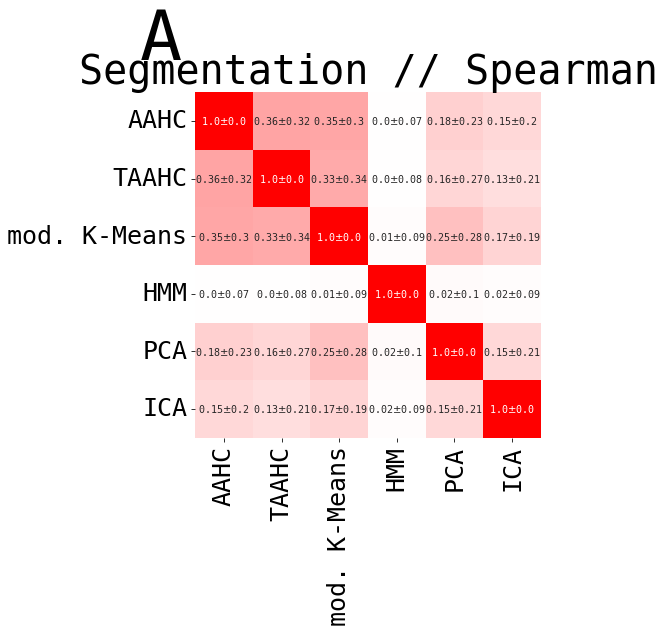

In [4]:
segm_mean = segm_corrs.mean().unstack().loc[COLUMNS_ORDER, COLUMNS_ORDER]
segm_mean.index.name = ""
segm_mean.columns.name = ""

segm_std = segm_corrs.std().unstack().loc[COLUMNS_ORDER, COLUMNS_ORDER]
segm_std.index.name = ""
segm_std.columns.name = ""

g1 = pw.Brick("ax0", figsize=(6, 6))
sns.heatmap(
    segm_mean,
    square=True,
    vmin=-1,
    vmax=1,
    cmap="bwr",
    annot=segm_mean.round(2).astype(str) + "$\pm$" + segm_std.round(2).astype(str),
    fmt="",
    ax=g1,
)
g1.set_title("Segmentation // Spearman")
g1.text(
    -0.1,
    1.15,
    "A",
    ha="center",
    va="center",
    transform=g1.transAxes,
    fontsize=70,
)
g1.savefig(quick=True)

In [5]:
stats = pd.read_csv(os.path.join(FOLDER, "stats.csv"))
stats = stats[(stats["surrogate_type"] == DATA_TYPE) & (stats["data_type"] == EOC)]
stats = stats.rename(columns={"decomposition_type": "algorithm"}).replace(
    {"hmm": "HMM", "kmeans": "mod. K-Means"}
)
stats = stats.sort_values(by="algorithm")

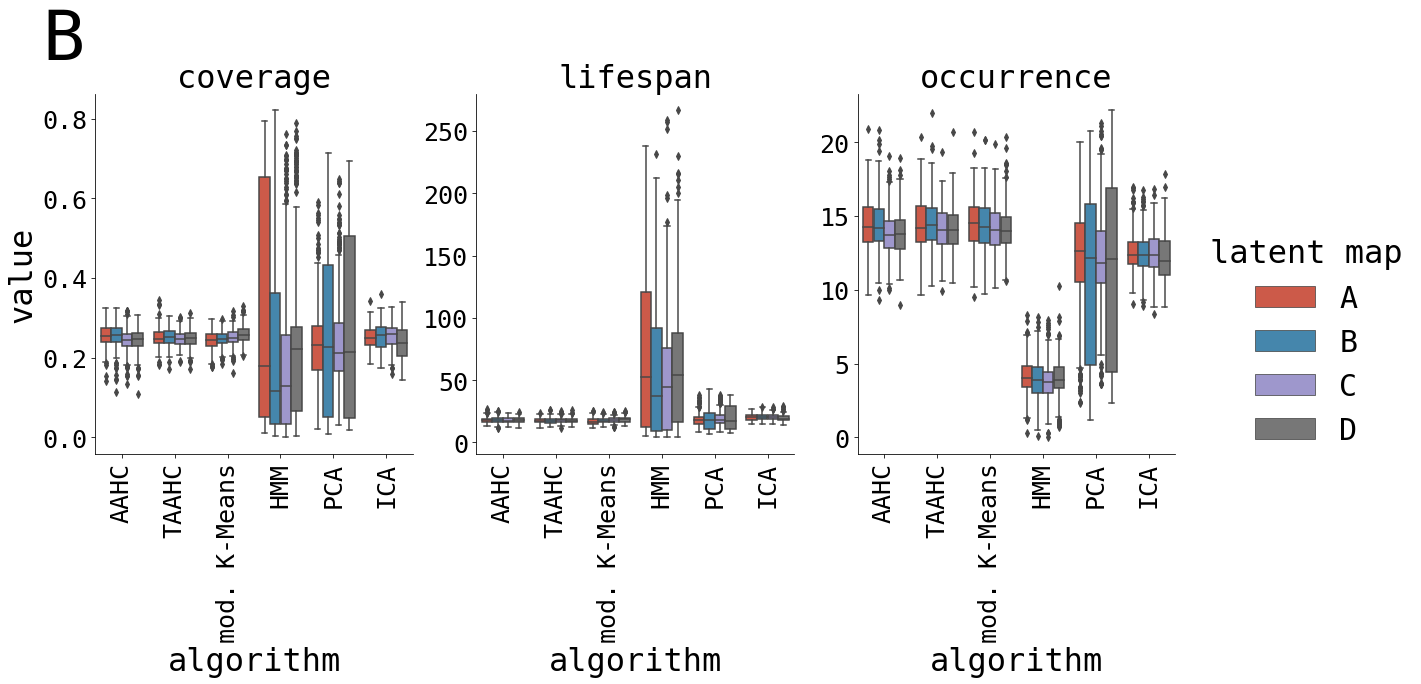

In [6]:
stats = (
    stats.rename(columns={"var_GFP": "var GFP", "var_total": "var total"})
    .set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
)
stats_melt = stats.melt(
    id_vars=["algorithm", "latent map"],
    value_vars=["coverage", "lifespan", "occurrence"],
)
g = sns.catplot(
    data=stats_melt,
    x="algorithm",
    y="value",
    hue="latent map",
    hue_order=["A", "B", "C", "D"],
    col="variable",
    sharex=True,
    sharey=False,
    margin_titles=True,
    kind="box",
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")
g.axes[0][0].text(
    -0.1,
    1.15,
    "B",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)

g2 = pw.load_seaborngrid(g)
g2.savefig(quick=True)

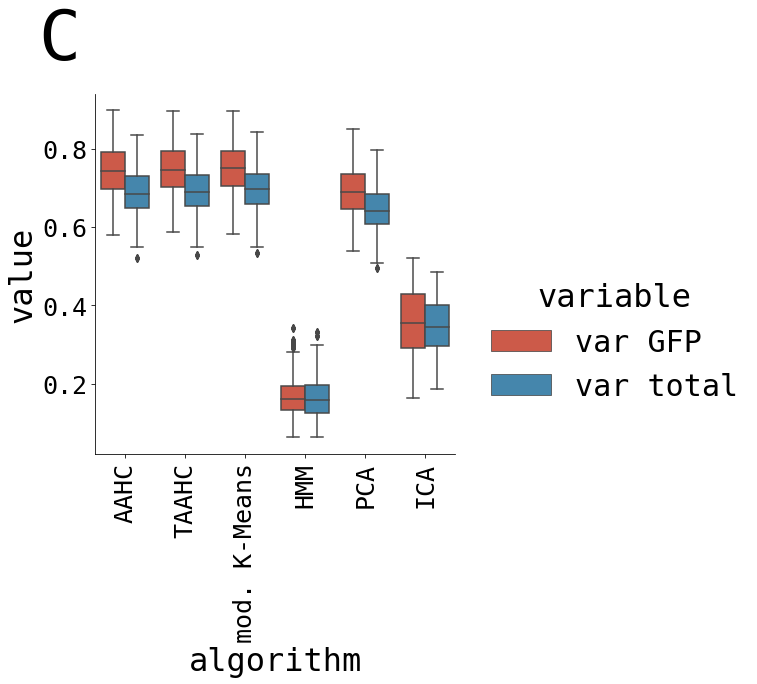

In [7]:
g = sns.catplot(
    data=stats.melt(id_vars="algorithm", value_vars=["var GFP", "var total"]),
    x="algorithm",
    y="value",
    hue="variable",
    kind="box",
)
g.set_xticklabels(COLUMNS_ORDER, rotation=90)
g.axes[0][0].text(
    -0.1,
    1.15,
    "C",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)

g3 = pw.load_seaborngrid(g)
g3.savefig(quick=True)

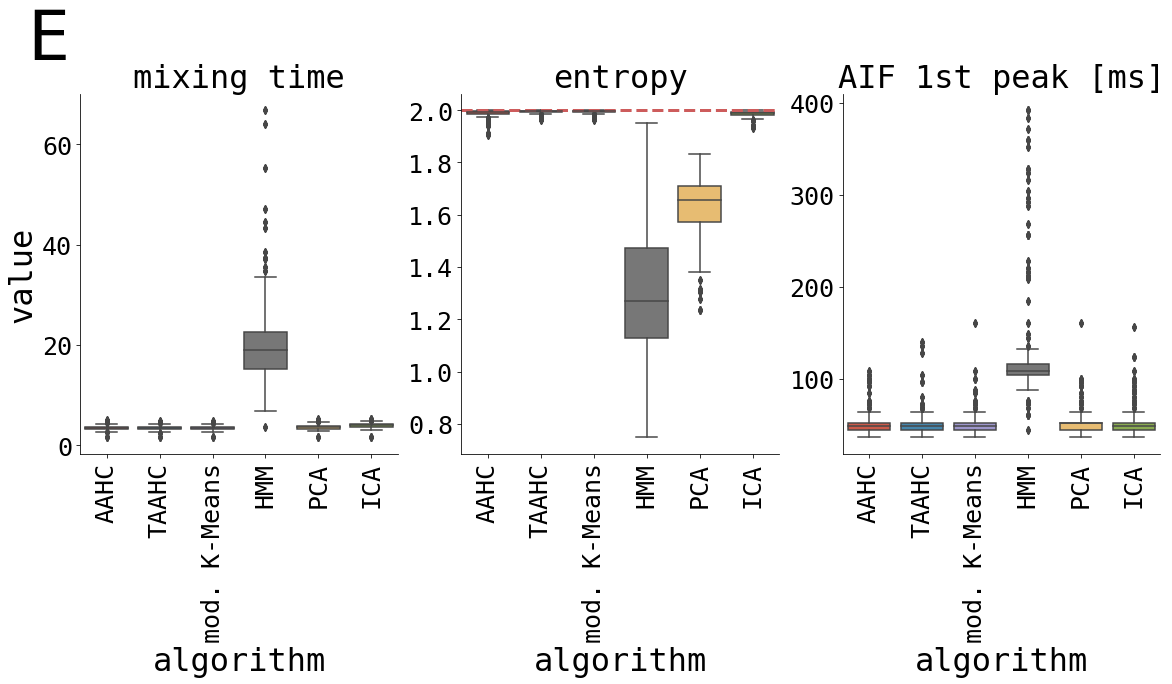

In [8]:
dynstats_melt = (
    stats.set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm"],
        value_vars=["mixing time", "entropy", "AIF 1st peak [ms]"],
    )
)
g = sns.catplot(
    data=dynstats_melt,
    x="algorithm",
    y="value",
    col="variable",
    sharex=True,
    sharey=False,
    margin_titles=True,
    kind="box",
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")
g.axes[0, 1].axhline(
    stats["max entropy"].unique()[0],
    linestyle="--",
    color="indianred",
    linewidth=3.0,
)
g.axes[0][0].text(
    -0.1,
    1.15,
    "E",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)
g4 = pw.load_seaborngrid(g)
g4.savefig(quick=True)

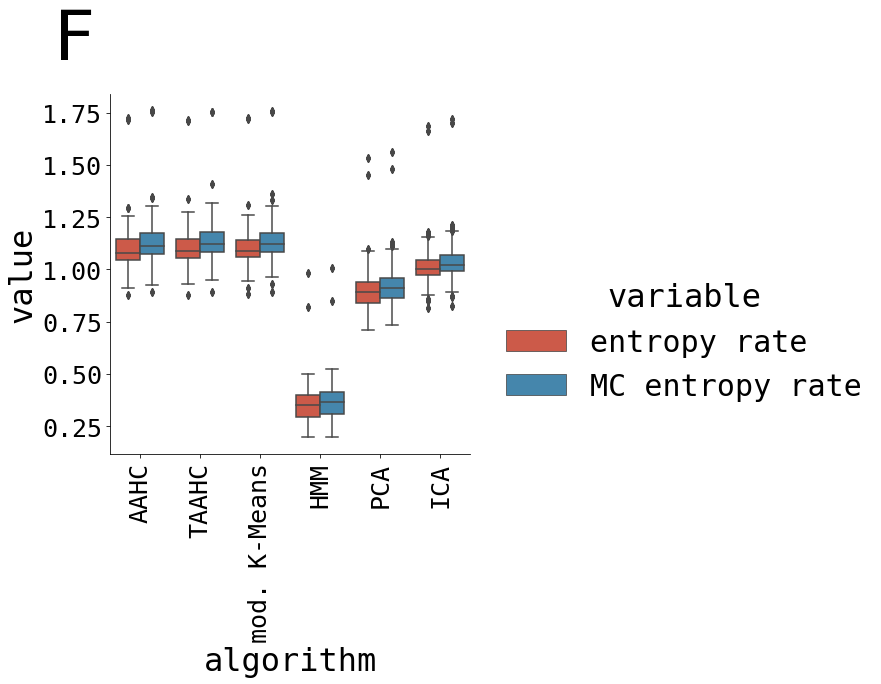

In [9]:
g = sns.catplot(
    data=stats.set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm"],
        value_vars=["entropy rate", "MC entropy rate"],
    ),
    x="algorithm",
    y="value",
    hue="variable",
    kind="box",
)
g.set_xticklabels(COLUMNS_ORDER, rotation=90)
g.axes[0][0].text(
    -0.1,
    1.15,
    "F",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)

g5 = pw.load_seaborngrid(g)
g5.savefig(quick=True)

In [10]:
subj_topo = (
    xr.open_dataarray(os.path.join(FOLDER, "topomaps.nc"))
    .squeeze()
    .sel({"data_type": EOC, "surrogate_type": DATA_TYPE})
    .rename({"decomposition_type": "algorithm"})
)
rename_algs = {
    "AAHC": "AAHC",
    "TAAHC": "TAAHC",
    "ICA": "ICA",
    "PCA": "PCA",
    "hmm": "HMM",
    "kmeans": "mod. K-Means",
}
subj_topo["algorithm"] = [
    rename_algs[str(alg.values)] for alg in subj_topo["algorithm"]
]
# subj_topo = subj_topo.stack(all=("data_type", "surrogate_type", "subject_id"))

In [11]:
subj_topo

<xarray.DataArray (algorithm: 6, subject_id: 203, latent map: 4, channels: 61)>
[297192 values with dtype=float64]
Coordinates:
  * subject_id      (subject_id) object 'sub-010002' ... 'sub-010321'
  * latent map      (latent map) object 'A' 'B' 'C' 'D'
  * channels        (channels) int64 0 1 2 3 4 5 6 7 ... 53 54 55 56 57 58 59 60
    no_states       int64 ...
  * algorithm       (algorithm) <U12 'AAHC' 'ICA' 'PCA' ... 'HMM' 'mod. K-Means'
    surrogate_type  <U9 'real_data'
    data_type       <U2 'EC'

In [12]:
all_corrs = []
for alg1 in subj_topo["algorithm"]:
    for alg2 in subj_topo["algorithm"]:
        for map1 in subj_topo["latent map"]:
            for map2 in subj_topo["latent map"]:
                corrs = (
                    xr.corr(
                        subj_topo.sel({"algorithm": alg1, "latent map": map1}),
                        subj_topo.sel({"algorithm": alg2, "latent map": map2}),
                        dim="channels",
                    )
                    .assign_coords(
                        {"alg1": alg1, "alg2": alg2, "map1": map1, "map2": map2}
                    )
                    .expand_dims(["alg1", "alg2", "map1", "map2"])
                )
                all_corrs.append(corrs)
all_corrs = np.abs(xr.combine_by_coords(all_corrs))

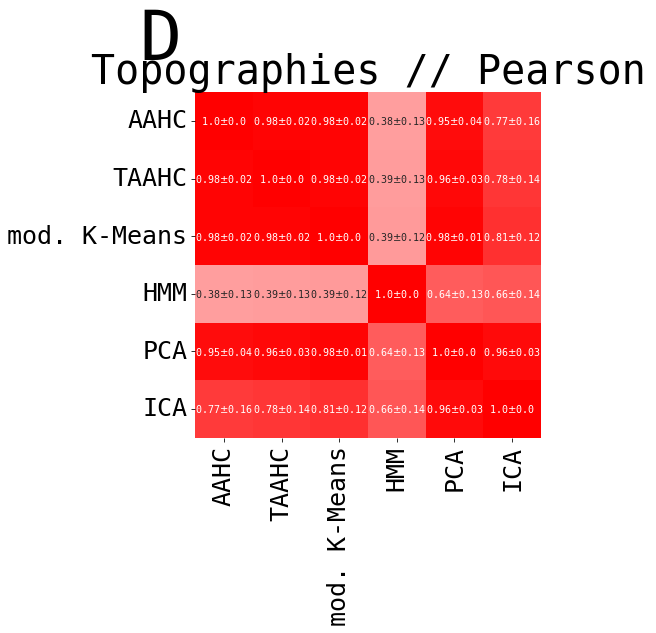

In [13]:
mean = (
    all_corrs.max(["map1", "map2"])
    .stack(algs=("alg1", "alg2"))
    .groupby("algs")
    .mean("subject_id")
    .unstack("algs")
    .to_series()
    .reset_index()
    .pivot(index="alg1", columns="alg2")
)
mean.index.name = ""
mean.columns = mean.columns.get_level_values(1)
mean.columns.name = ""
mean = mean.rename(
    columns={"kmeans": "mod. K-Means"}, index={"kmeans": "mod. K-Means"}
).loc[COLUMNS_ORDER, COLUMNS_ORDER]

std = (
    all_corrs.max(["map1", "map2"])
    .stack(algs=("alg1", "alg2"))
    .groupby("algs")
    .std("subject_id", ddof=1)
    .unstack("algs")
    .to_series()
    .reset_index()
    .pivot(index="alg1", columns="alg2")
)
std.index.name = ""
std.columns = std.columns.get_level_values(1)
std.columns.name = ""
std = std.rename(
    columns={"kmeans": "mod. K-Means"}, index={"kmeans": "mod. K-Means"}
).loc[COLUMNS_ORDER, COLUMNS_ORDER]

g6 = pw.Brick("ax2", figsize=(6, 6))
sns.heatmap(
    mean,
    square=True,
    vmin=-1,
    vmax=1,
    cmap="bwr",
    annot=mean.round(2).astype(str) + "$\pm$" + std.round(2).astype(str),
    fmt="",
    ax=g6,
)
g6.text(
    -0.1,
    1.15,
    "D",
    ha="center",
    va="center",
    transform=g6.transAxes,
    fontsize=70,
)
g6.set_title("Topographies // Pearson")
g6.savefig(quick=True)

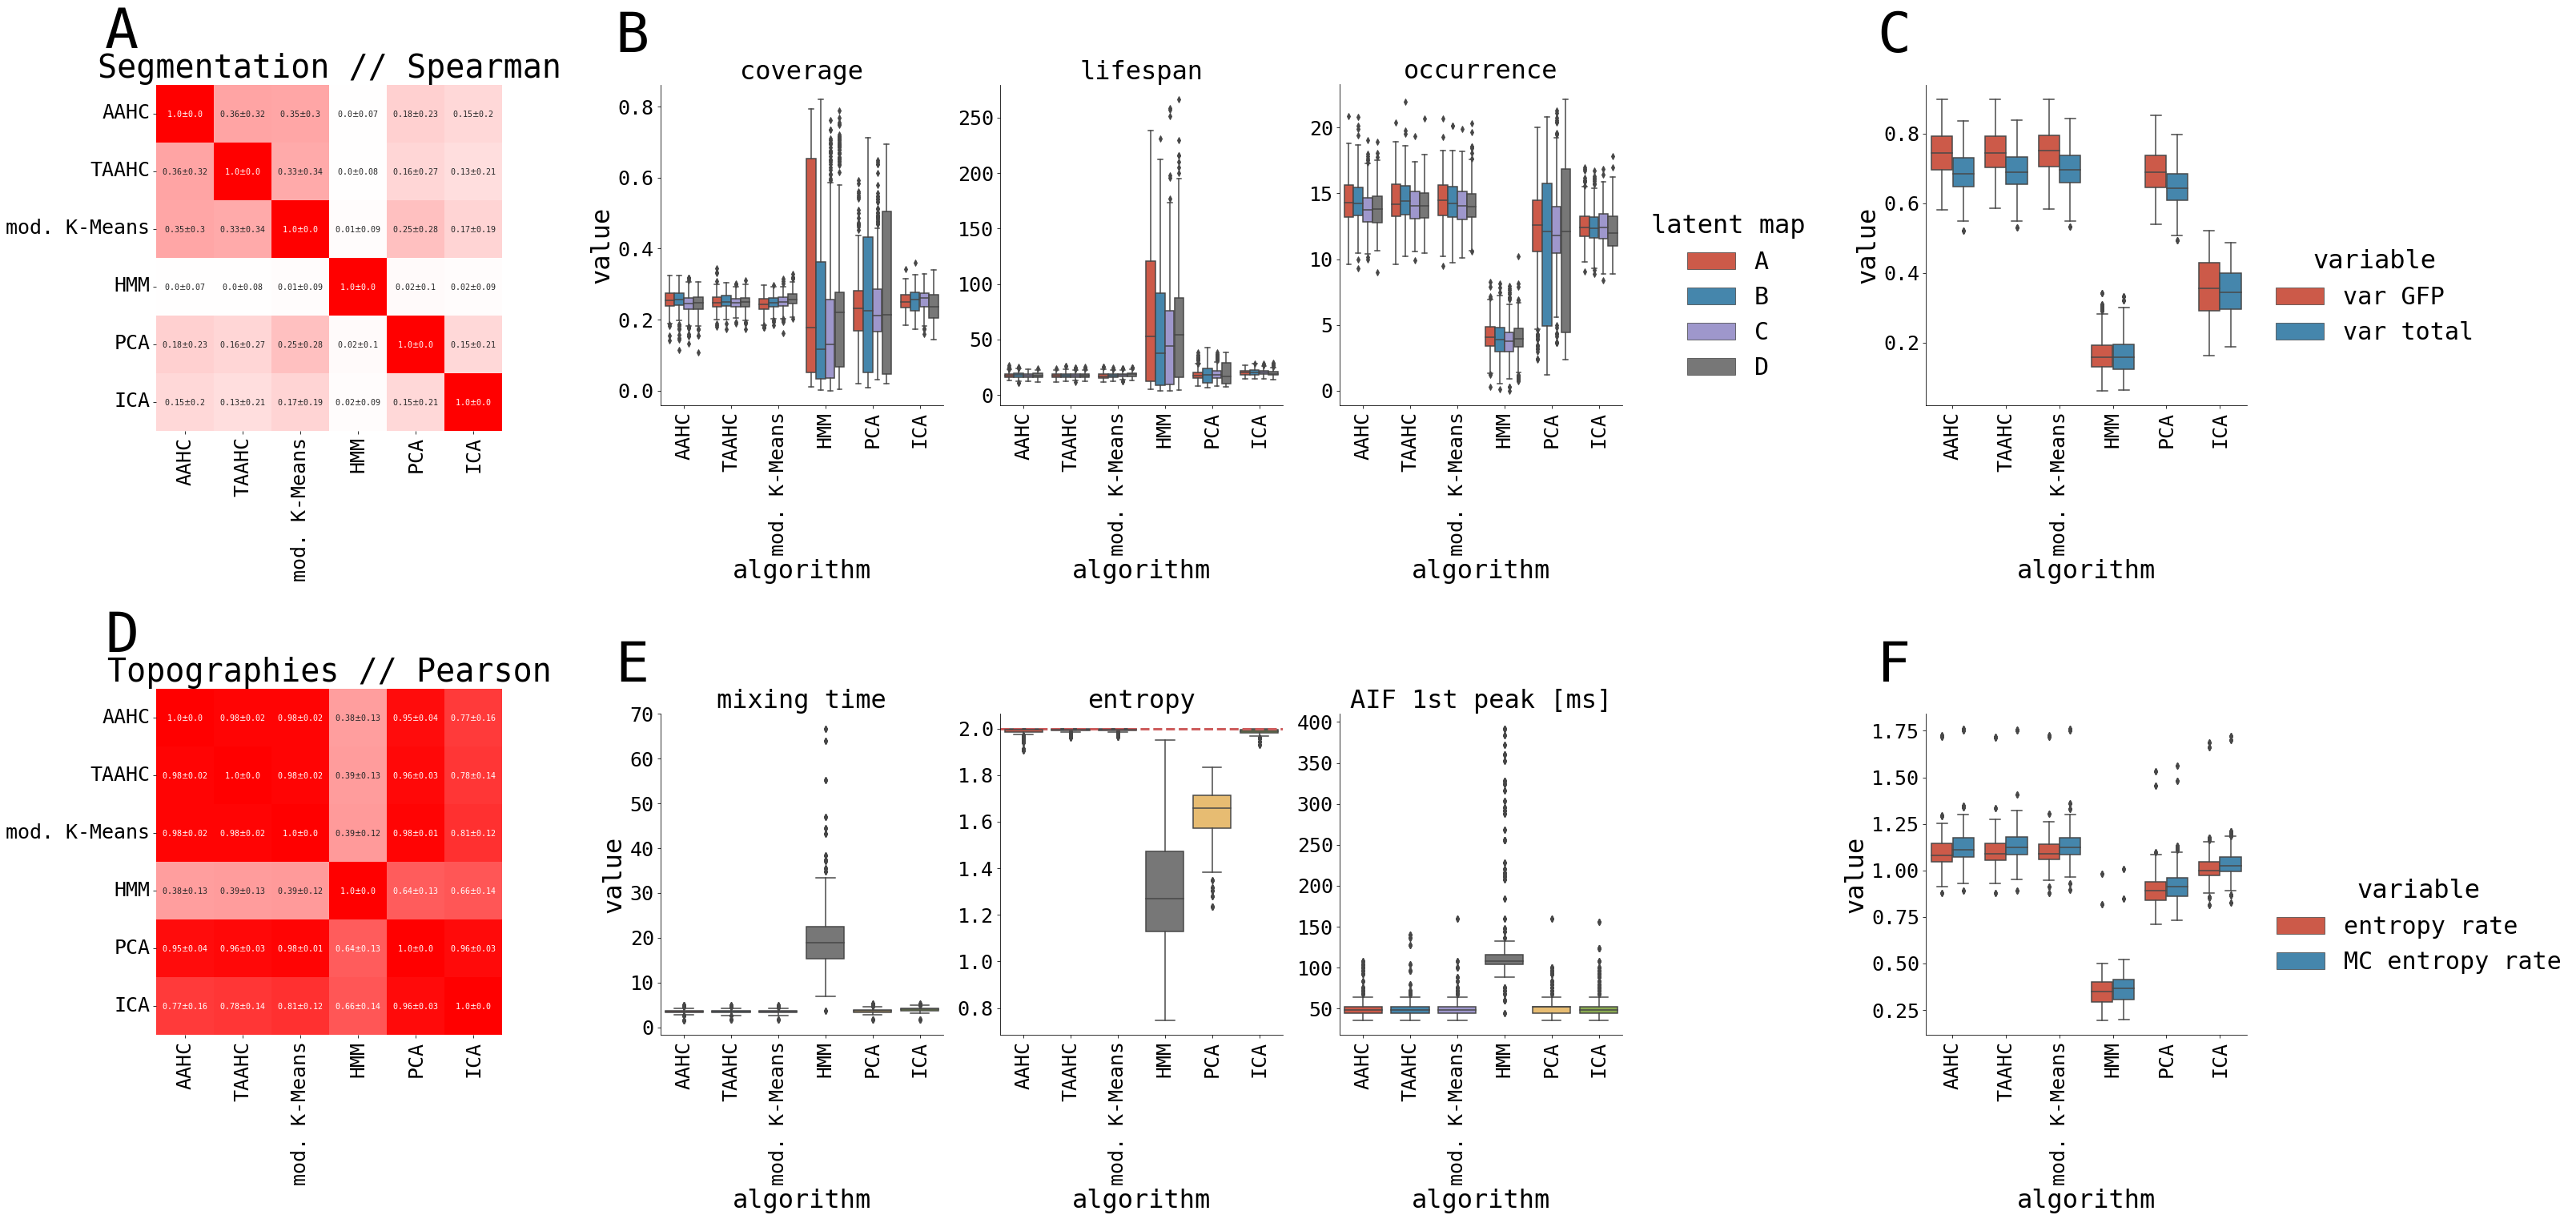

In [14]:
((g1 / g6) | (g2 / g4) | (g3 / g5)).savefig(
    fname=f"LEMON_{DATA_TYPE}_{EOC}_stats.pdf", transparent=True
)

In [15]:
rename_algs = {
    "AAHC": "AAHC",
    "TAAHC": "TAAHC",
    "ICA": "ICA",
    "PCA": "PCA",
    "hmm": "HMM",
    "kmeans": "mod. K-Means",
}
segmentations["algorithm"] = [
    rename_algs[str(alg.values)] for alg in segmentations["algorithm"]
]
segmentations

<xarray.DataArray (algorithm: 6, subject_id: 203, time: 62501)>
array([[[ 1.,  2., ..., nan, nan],
        [ 3.,  0., ..., nan, nan],
        ...,
        [ 0.,  0., ..., nan, nan],
        [ 2.,  2., ..., nan, nan]],

       [[ 1.,  1., ...,  2.,  3.],
        [ 0.,  2., ...,  1.,  1.],
        ...,
        [ 1.,  1., ...,  1.,  0.],
        [ 1.,  2., ...,  0.,  1.]],

       ...,

       [[ 3.,  0., ...,  3.,  3.],
        [ 1.,  1., ...,  2.,  2.],
        ...,
        [ 1.,  1., ...,  3.,  3.],
        [ 1.,  1., ...,  1.,  1.]],

       [[ 0.,  0., ...,  1.,  2.],
        [ 0.,  2., ...,  0.,  2.],
        ...,
        [ 0.,  0., ...,  0.,  0.],
        [ 3.,  2., ...,  0.,  2.]]])
Coordinates:
  * subject_id      (subject_id) object 'sub-010002' ... 'sub-010321'
  * time            (time) float64 0.0 0.004 0.008 0.012 ... 250.0 250.0 250.0
    no_states       int64 ...
  * algorithm       (algorithm) <U12 'AAHC' 'ICA' 'PCA' ... 'HMM' 'mod. K-Means'
    surrogate_type  <U9 'real_data'
    data_type       <U2 'EC'

In [16]:
RND_SUBJECT = f"sub-010005_{EOC}"
subj_data = mne.io.read_raw_eeglab(f"../../data/test_data_LEMON/{RND_SUBJECT}.set", preload=True)
subj_data.crop(tmax=250.0)
subj_data = pd.DataFrame(subj_data.get_data().T, columns=subj_data.info["ch_names"], index=segmentations.time)
peaks, _ = get_gfp_peaks(
    subj_data.values.T,
    min_peak_dist=2,
    smoothing=None,
    smoothing_window=100,
)
subj_data["GFP"] = False
subj_data.iloc[peaks, -1] = True
subj_data

Reading /Users/nikola/work-brain/eeg_microstate_and_latent_space/notebooks/paper1_figs/../../data/test_data_LEMON/sub-010005_EC.fdt
Reading 0 ... 119999  =      0.000 ...   479.996 secs...


,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,...,P5,P1,P2,P6,PO7,PO3,POz,PO4,PO8,GFP
0.000,6.397504e-06,6.078753e-06,0.000006,7.085958e-07,-3.777474e-07,2.901564e-06,5.377050e-06,5.031381e-07,-2.247505e-06,1.981300e-06,...,-8.224872e-06,-5.776766e-06,-5.301002e-06,-0.000007,-0.000012,-1.473635e-05,-1.279143e-05,-0.000008,-5.732491e-06,False
0.004,4.569060e-06,2.889032e-06,0.000005,5.730301e-07,-1.619197e-06,1.122734e-06,2.619161e-06,1.473029e-06,-1.496726e-06,2.504624e-06,...,-7.509490e-06,-7.515203e-07,5.565836e-07,-0.000002,-0.000013,-1.119396e-05,-7.120273e-06,-0.000002,-9.250420e-07,False
0.008,2.497874e-06,-5.359106e-07,0.000004,5.817405e-07,-2.864929e-06,-7.558413e-07,1.519326e-07,2.966741e-06,-2.236831e-07,2.578319e-06,...,-5.392640e-06,4.160406e-06,6.475244e-06,0.000005,-0.000012,-5.709144e-06,-3.332286e-07,0.000006,5.735481e-06,False
0.012,5.246660e-08,-3.850643e-06,0.000003,4.360846e-07,-3.917741e-06,-2.259639e-06,-2.641568e-06,4.254062e-06,9.986317e-07,2.655300e-06,...,-2.757459e-06,8.451418e-06,1.190490e-05,0.000012,-0.000009,1.059140e-07,6.139275e-06,0.000013,1.194093e-05,False
0.016,-2.008163e-06,-6.058713e-06,0.000001,3.633624e-07,-4.093926e-06,-2.792943e-06,-4.623453e-06,4.437024e-06,1.864204e-06,2.862002e-06,...,-5.385735e-07,1.158399e-05,1.617574e-05,0.000017,-0.000007,5.076192e-06,1.137342e-05,0.000018,1.644082e-05,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249.984,-4.466836e-06,-3.629943e-06,-0.000005,-2.882055e-06,-2.060512e-06,-2.226596e-06,-3.958615e-07,-4.123589e-06,1.314353e-06,6.404722e-08,...,9.584959e-07,6.405121e-06,8.983759e-06,0.000012,0.000003,1.272087e-05,1.111982e-05,0.000009,9.795730e-06,False
249.988,-4.913551e-06,-2.179130e-06,-0.000006,-4.407039e-06,-1.919830e-06,-2.317103e-07,8.597703e-07,-5.739203e-06,2.943179e-07,1.246792e-06,...,1.404875e-06,7.847285e-06,1.040977e-05,0.000013,0.000005,1.559571e-05,1.455034e-05,0.000012,1.086083e-05,False
249.992,-5.766574e-06,-1.656663e-06,-0.000007,-5.850427e-06,-1.849524e-06,1.106039e-06,4.636575e-07,-7.398064e-06,-7.763813e-07,2.113952e-06,...,8.124002e-07,7.967866e-06,1.043441e-05,0.000012,0.000005,1.658329e-05,1.630055e-05,0.000013,1.007214e-05,True
249.996,-5.810929e-06,-1.134845e-06,-0.000008,-6.014152e-06,-1.303356e-06,1.685120e-06,-4.928783e-07,-8.089655e-06,-1.292879e-06,2.275467e-06,...,-3.785644e-07,7.045539e-06,9.475282e-06,0.000009,0.000004,1.605315e-05,1.640465e-05,0.000013,8.118641e-06,False


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

segmentation_subject = segmentations.sel({"subject_id": RND_SUBJECT[:-3]}).isel({"time": subj_data["GFP"]})
# segmentation_subject.sel({"algorithm": "mod. K-Means"})
scaler = StandardScaler()
svm_data = subj_data[subj_data["GFP"]].drop("GFP", axis=1)
svm_data = pd.DataFrame(scaler.fit_transform(svm_data), index=svm_data.index, columns=svm_data.columns)
svm_data["K-Means"] = segmentation_subject.sel({"algorithm": "mod. K-Means"}).values
svm_data
svc = SVC(kernel="linear", decision_function_shape="ovr")
svc.fit(svm_data.iloc[:, :-1], svm_data.iloc[:, -1])
svc.support_vectors_.shape, svc.classes_, svc.n_support_, svc.support_.shape


((5665, 61),
 array([0., 1., 2., 3.]),
 array([1394, 1625, 1191, 1455], dtype=int32),
 (5665,))

In [29]:
svc = SVC(kernel="linear", decision_function_shape="ovr")
svc.fit(svm_data.iloc[:, :-1], svm_data.iloc[:, -1])
print(svc.support_vectors_.shape, svc.classes_, svc.n_support_, svc.support_.shape)

svc = SVC(kernel="rbf", decision_function_shape="ovr")
svc.fit(svm_data.iloc[:, :-1], svm_data.iloc[:, -1])
print(svc.support_vectors_.shape, svc.classes_, svc.n_support_, svc.support_.shape)

svc = SVC(kernel="poly", decision_function_shape="ovr")
svc.fit(svm_data.iloc[:, :-1], svm_data.iloc[:, -1])
print(svc.support_vectors_.shape, svc.classes_, svc.n_support_, svc.support_.shape)

svc = SVC(kernel="sigmoid", decision_function_shape="ovr")
svc.fit(svm_data.iloc[:, :-1], svm_data.iloc[:, -1])
print(svc.support_vectors_.shape, svc.classes_, svc.n_support_, svc.support_.shape)

(5665, 61) [0. 1. 2. 3.] [1394 1625 1191 1455] (5665,)
(2997, 61) [0. 1. 2. 3.] [760 842 637 758] (2997,)
(5617, 61) [0. 1. 2. 3.] [1387 1597 1176 1457] (5617,)
(4660, 61) [0. 1. 2. 3.] [1193  910 1110 1447] (4660,)


In [25]:
svc = SVC(kernel="linear", decision_function_shape="ovr")
svc.fit(svm_data.iloc[:, :-1], svm_data.iloc[:, -1].replace({1.0: 1., 2.0: 1., 3.0: 1.}))
svc.support_vectors_.shape, svc.classes_, svc.n_support_, svc.support_.shape

# dimred = PCA(n_components=5)
# plot_d = dimred.fit_transform(svm_data.iloc[:, :-1])
# plot_d = pd.DataFrame(plot_d, index=svm_data.index, columns=[f"PC_{i}" for i in range(5)])

# g = sns.pairplot(plot_d)
# g20 = pw.load_seaborngrid(g)
# g20.savefig(quick=True)

((3271, 61), array([0., 1.]), array([1394, 1877], dtype=int32), (3271,))

In [17]:
def get_pca(algo, n_comps=5):
    pca = PCA(n_components=n_comps)
    pca_data = subj_data[subj_data["GFP"]]
    pcs = pca.fit_transform(pca_data.values)
    pcs = pd.DataFrame(
        pcs, columns=[f"PC {i}" for i in range(n_comps)], index=pca_data.index
    )
    pcs[algo] = segmentations.sel({"subject_id": RND_SUBJECT[:-3], "algorithm": algo, "time": subj_data[subj_data["GFP"]].index.values})

    g = sns.PairGrid(pcs, vars=[f"PC {i}" for i in range(n_comps)], hue=algo)
    g.map_diag(sns.histplot, bins=30, alpha=0.5)
    g.map_offdiag(sns.scatterplot)
    g.axes[0, 0].set_title(algo)

    return g

In [18]:
for comp in range(2, 6):
    g10 = pw.load_seaborngrid(get_pca("AAHC", n_comps=comp))
    g11 = pw.load_seaborngrid(get_pca("TAAHC", n_comps=comp))
    g12 = pw.load_seaborngrid(get_pca("mod. K-Means", n_comps=comp))
    g13 = pw.load_seaborngrid(get_pca("HMM", n_comps=comp))
    g14 = pw.load_seaborngrid(get_pca("PCA", n_comps=comp))
    g15 = pw.load_seaborngrid(get_pca("ICA", n_comps=comp))
    ((g10 | g11 | g12) / (g13 | g14 | g15)).savefig(
        fname=f"LEMON_{EOC}_{RND_SUBJECT}_GFP_lowdim_{comp}.png"
        # quick=True
    )

In [19]:
def get_pca(decomp, n_comps=2):
    data = (
        subj_topo.stack(samples=("subject_id", "latent map"))
        .sel({"algorithm": decomp})
        .where(
            (
                subj_topo.stack(samples=("subject_id", "latent map")).sel(
                    {"algorithm": decomp}
                )
                < subj_topo.stack(samples=("subject_id", "latent map"))
                .sel({"algorithm": decomp})
                .quantile(0.99)
            )
            & (
                subj_topo.stack(samples=("subject_id", "latent map")).sel(
                    {"algorithm": decomp}
                )
                > subj_topo.stack(samples=("subject_id", "latent map"))
                .sel({"algorithm": decomp})
                .quantile(0.01)
            )
        )
        .dropna("samples")
        .dropna("channels")
    )
    pca = PCA(n_components=n_comps)
    pcs = pca.fit_transform(data.values.T)
    low_dim = pd.DataFrame(pcs, columns=[f"PC {i}" for i in range(n_comps)])
    low_dim["map"] = data["latent map"]
    g = sns.PairGrid(low_dim, vars=[f"PC {i}" for i in range(n_comps)], hue="map")
    g.map_diag(sns.histplot, bins=30, alpha=0.5)
    g.map_offdiag(sns.scatterplot)
    g.axes[0, 1].set_title(decomp)
    return g


def get_tsne(decomp, n_comps=2):
    data = (
        subj_topo.stack(samples=("subject_id", "latent map"))
        .sel({"algorithm": decomp})
        .where(
            (
                subj_topo.stack(samples=("subject_id", "latent map")).sel(
                    {"algorithm": decomp}
                )
                < subj_topo.stack(samples=("subject_id", "latent map"))
                .sel({"algorithm": decomp})
                .quantile(0.99)
            )
            & (
                subj_topo.stack(samples=("subject_id", "latent map")).sel(
                    {"algorithm": decomp}
                )
                > subj_topo.stack(samples=("subject_id", "latent map"))
                .sel({"algorithm": decomp})
                .quantile(0.01)
            )
        )
        .dropna("samples")
        .dropna("channels")
    )
    tsne = TSNE(n_components=n_comps, init="pca", n_jobs=6, method="exact")
    pcs = tsne.fit_transform(data.values.T)
    low_dim = pd.DataFrame(pcs, columns=[f"t-SNE {i}" for i in range(n_comps)])
    low_dim["map"] = data["latent map"]
    g = sns.PairGrid(low_dim, vars=[f"t-SNE {i}" for i in range(n_comps)], hue="map")
    g.map_diag(sns.histplot, bins=30, alpha=0.5)
    g.map_offdiag(sns.scatterplot)
    return g


def get_mds(decomp, n_comps=2):
    data = (
        subj_topo.stack(samples=("subject_id", "latent map"))
        .sel({"algorithm": decomp})
        .where(
            (
                subj_topo.stack(samples=("subject_id", "latent map")).sel(
                    {"algorithm": decomp}
                )
                < subj_topo.stack(samples=("subject_id", "latent map"))
                .sel({"algorithm": decomp})
                .quantile(0.99)
            )
            & (
                subj_topo.stack(samples=("subject_id", "latent map")).sel(
                    {"algorithm": decomp}
                )
                > subj_topo.stack(samples=("subject_id", "latent map"))
                .sel({"algorithm": decomp})
                .quantile(0.01)
            )
        )
        .dropna("samples")
        .dropna("channels")
    )
    mds = MDS(n_components=n_comps, n_jobs=6)
    pcs = mds.fit_transform(data.values.T)
    low_dim = pd.DataFrame(pcs, columns=[f"MDS {i}" for i in range(n_comps)])
    low_dim["map"] = data["latent map"]
    g = sns.PairGrid(low_dim, vars=[f"MDS {i}" for i in range(n_comps)], hue="map")
    g.map_diag(sns.histplot, bins=30, alpha=0.5)
    g.map_offdiag(sns.scatterplot)
    return g


def get_lle(decomp, n_comps=2):
    data = (
        subj_topo.stack(samples=("subject_id", "latent map"))
        .sel({"algorithm": decomp})
        .where(
            (
                subj_topo.stack(samples=("subject_id", "latent map")).sel(
                    {"algorithm": decomp}
                )
                < subj_topo.stack(samples=("subject_id", "latent map"))
                .sel({"algorithm": decomp})
                .quantile(0.99)
            )
            & (
                subj_topo.stack(samples=("subject_id", "latent map")).sel(
                    {"algorithm": decomp}
                )
                > subj_topo.stack(samples=("subject_id", "latent map"))
                .sel({"algorithm": decomp})
                .quantile(0.01)
            )
        )
        .dropna("samples")
        .dropna("channels")
    )
    lle = LocallyLinearEmbedding(n_components=n_comps, n_neighbors=10, n_jobs=6)
    pcs = lle.fit_transform(data.values.T)
    low_dim = pd.DataFrame(pcs, columns=[f"LLE {i}" for i in range(n_comps)])
    low_dim["map"] = data["latent map"]
    g = sns.PairGrid(low_dim, vars=[f"LLE {i}" for i in range(n_comps)], hue="map")
    g.map_diag(sns.histplot, bins=30, alpha=0.5)
    g.map_offdiag(sns.scatterplot)
    return g


# maps["algorithm"] = ["AAHC", "HMM", "ICA", "PCA", "TAAHC", "mod. K-Means"]


for comp in range(2, 5):
    g = get_pca("AAHC", n_comps=comp)
    g10 = pw.load_seaborngrid(g)
    g11 = pw.load_seaborngrid(get_pca("TAAHC", n_comps=comp))
    g12 = pw.load_seaborngrid(get_pca("mod. K-Means", n_comps=comp))
    g13 = pw.load_seaborngrid(get_pca("HMM", n_comps=comp))
    g14 = pw.load_seaborngrid(get_pca("PCA", n_comps=comp))
    g15 = pw.load_seaborngrid(get_pca("ICA", n_comps=comp))

    g20 = pw.load_seaborngrid(get_tsne("AAHC", n_comps=comp))
    g21 = pw.load_seaborngrid(get_tsne("TAAHC", n_comps=comp))
    g22 = pw.load_seaborngrid(get_tsne("mod. K-Means", n_comps=comp))
    g23 = pw.load_seaborngrid(get_tsne("HMM", n_comps=comp))
    g24 = pw.load_seaborngrid(get_tsne("PCA", n_comps=comp))
    g25 = pw.load_seaborngrid(get_tsne("ICA", n_comps=comp))

    g30 = pw.load_seaborngrid(get_mds("AAHC", n_comps=comp))
    g31 = pw.load_seaborngrid(get_mds("TAAHC", n_comps=comp))
    g32 = pw.load_seaborngrid(get_mds("mod. K-Means", n_comps=comp))
    g33 = pw.load_seaborngrid(get_mds("HMM", n_comps=comp))
    g34 = pw.load_seaborngrid(get_mds("PCA", n_comps=comp))
    g35 = pw.load_seaborngrid(get_mds("ICA", n_comps=comp))

    g40 = pw.load_seaborngrid(get_lle("AAHC", n_comps=comp))
    g41 = pw.load_seaborngrid(get_lle("TAAHC", n_comps=comp))
    g42 = pw.load_seaborngrid(get_lle("mod. K-Means", n_comps=comp))
    g43 = pw.load_seaborngrid(get_lle("HMM", n_comps=comp))
    g44 = pw.load_seaborngrid(get_lle("PCA", n_comps=comp))
    g45 = pw.load_seaborngrid(get_lle("ICA", n_comps=comp))
    
    (
        (g10 | g11 | g12 | g13 | g14 | g15)
        / (g20 | g21 | g22 | g23 | g24 | g25)
        / (g30 | g31 | g32 | g33 | g34 | g35)
        / (g40 | g41 | g42 | g43 | g44 | g45)
    ).savefig(fname=f"all_subjects_LEMON_{DATA_TYPE}_{EOC}lowdim_repr_{comp}.png")